# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from math import ceil
from datetime import date
import os

# ML modeling
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

RS = 42

# Data read
## Train / Test Datasets construction

In [2]:
train_health = pd.read_excel('train_health.xlsx')
train_habits = pd.read_excel('train_habits.xlsx')
train_demo = pd.read_excel('train_demo.xlsx')

In [3]:
train_health.head(2)

,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
0,1167,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.
1,1805,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.


In [4]:
train_habits.head(2)

,PatientID,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit
0,1167,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters
1,1805,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters


In [5]:
train_demo.head(2)

,PatientID,Name,Birth_Year,Region,Education,Disease
0,1167,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1
1,1805,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1


In [6]:
train_merge = train_health.merge(train_habits, how='inner')

In [7]:
train_df = train_merge.merge(train_demo, how='inner')

In [8]:
train_df.head(2)

,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Name,Birth_Year,Region,Education,Disease
0,1167,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1
1,1805,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1


## Test Datasets

In [9]:
test_health = pd.read_excel('test_health.xlsx')
test_habits = pd.read_excel('test_habits.xlsx')
test_demo = pd.read_excel('test_demo.xlsx')

In [10]:
test_health.head(3)

,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
0,1343,172,80,203,172,20,2,Not sure,I have/had pregnancy diabetes or borderline di...
1,1727,171,80,225,130,21,0,Not sure,I do have diabetes
2,1828,171,78,237,130,24,1,More than 3 years,I have/had pregnancy diabetes or borderline di...


In [11]:
test_habits.head(3)

,PatientID,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit
0,1343,Yes,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters
1,1727,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter
2,1828,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters


In [12]:
test_demo.head(3)

,PatientID,Name,Birth_Year,Region,Education
0,1343,Mr. Ricardo Sherman,1970,East Midlands,Elementary School (1st to 9th grade)
1,1727,Mr. Jessie Strickland,1966,Yorkshire and the Humber,University Complete (3 or more years)
2,1828,Mr. Robert Foreman,1978,West Midlands,High School Incomplete (10th to 11th grade)


In [13]:
test_merge1 = test_health.merge(test_habits, how='inner')
test_merge1.head(3)

,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit
0,1343,172,80,203,172,20,2,Not sure,I have/had pregnancy diabetes or borderline di...,Yes,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters
1,1727,171,80,225,130,21,0,Not sure,I do have diabetes,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter
2,1828,171,78,237,130,24,1,More than 3 years,I have/had pregnancy diabetes or borderline di...,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters


In [14]:
test_df = test_merge1.merge(test_demo, how='inner')
test_df.head(3)

,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Name,Birth_Year,Region,Education
0,1343,172,80,203,172,20,2,Not sure,I have/had pregnancy diabetes or borderline di...,Yes,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mr. Ricardo Sherman,1970,East Midlands,Elementary School (1st to 9th grade)
1,1727,171,80,225,130,21,0,Not sure,I do have diabetes,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,Mr. Jessie Strickland,1966,Yorkshire and the Humber,University Complete (3 or more years)
2,1828,171,78,237,130,24,1,More than 3 years,I have/had pregnancy diabetes or borderline di...,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mr. Robert Foreman,1978,West Midlands,High School Incomplete (10th to 11th grade)


In [15]:

print(f'Train data size: {train_df.shape[0]} x {train_df.shape[1]}')
print(f'Test data size: {test_df.shape[0]} x {test_df.shape[1]}')

pid = list(test_df.index)
data = pd.concat([train_df, test_df]).reset_index()
data.drop(columns = 'index', inplace = True)
data

Train data size: 800 x 19
Test data size: 225 x 18


,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Name,Birth_Year,Region,Education,Disease
0,1167,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1.0
1,1805,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1.0
2,1557,162,68,226,122,26,0,More than 3 years,Neither I nor my immediate family have diabetes.,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,Mr. Mark Boller,1974,Yorkshire and the Humber,Elementary School (1st to 9th grade),1.0
3,1658,180,66,313,125,13,8,Not sure,I have/had pregnancy diabetes or borderline di...,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,Mr. David Caffee,1958,London,University Complete (3 or more years),0.0
4,1544,180,58,277,125,18,2,More than 3 years,I have/had pregnancy diabetes or borderline di...,No,I consider myself a social drinker,No,1 to 2 pieces of fruit in average,More than half a liter but less than one liter,Mr. Gerald Emery,1968,South East,University Incomplete (1 to 2 years),1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1000,178,89,216,125,22,4,Not sure,Neither I nor my immediate family have diabetes.,No,I usually consume alcohol every day,No,3 to 4 pieces of fruit in average,More than half a liter but less than one liter,Mr. John Eichhorn,1970,East Midlands,University Incomplete (1 to 2 years),NaN
1021,1256,154,63,187,138,25,6,More than 3 years,Neither I nor my immediate family have diabetes.,No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Less than half a liter,Mrs. Tiffany Medley,1987,West Midlands,University Complete (3 or more years),NaN
1022,1318,173,90,181,140,20,0,Not sure,Neither I nor my immediate family have diabetes.,No,I usually consume alcohol every day,Yes,1 to 2 pieces of fruit in average,Between one liter and two liters,Mr. Kenneth Crase,1963,East Midlands,High School Graduate,NaN
1023,1953,155,45,240,138,18,0,More than 3 years,Neither I nor my immediate family have diabetes.,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,Mrs. Tracy Williams,1977,East Midlands,High School Incomplete (10th to 11th grade),NaN


# Data observation

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PatientID         1025 non-null   int64  
 1   Height            1025 non-null   int64  
 2   Weight            1025 non-null   int64  
 3   High_Cholesterol  1025 non-null   int64  
 4   Blood_Pressure    1025 non-null   int64  
 5   Mental_Health     1025 non-null   int64  
 6   Physical_Health   1025 non-null   int64  
 7   Checkup           1025 non-null   object 
 8   Diabetes          1025 non-null   object 
 9   Smoking_Habit     1025 non-null   object 
 10  Drinking_Habit    1025 non-null   object 
 11  Exercise          1025 non-null   object 
 12  Fruit_Habit       1025 non-null   object 
 13  Water_Habit       1025 non-null   object 
 14  Name              1025 non-null   object 
 15  Birth_Year        1025 non-null   int64  
 16  Region            1025 non-null   object 


In [17]:
# Get numbers of unique observations
for col in data.columns:
  print(f'{col}: {data[col].nunique()} unique values')

PatientID: 1025 unique values
Height: 15 unique values
Weight: 58 unique values
High_Cholesterol: 152 unique values
Blood_Pressure: 49 unique values
Mental_Health: 28 unique values
Physical_Health: 24 unique values
Checkup: 4 unique values
Diabetes: 4 unique values
Smoking_Habit: 2 unique values
Drinking_Habit: 3 unique values
Exercise: 2 unique values
Fruit_Habit: 5 unique values
Water_Habit: 3 unique values
Name: 1023 unique values
Birth_Year: 50 unique values
Region: 10 unique values
Education: 6 unique values
Disease: 2 unique values


In [18]:
data.describe()

,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Birth_Year,Disease
count,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,800.000000
mean,1512.000000,167.721951,67.821463,250.00000,131.611707,17.389268,4.738537,1966.395122,0.513750
std,296.036315,7.982877,12.251687,51.59251,17.516718,5.281313,5.596449,14.335373,0.500124
min,1000.000000,151.000000,40.000000,130.00000,94.000000,0.000000,0.000000,1855.000000,0.000000
25%,1256.000000,162.000000,58.000000,215.00000,120.000000,13.000000,0.000000,1961.000000,0.000000
50%,1512.000000,167.000000,68.000000,244.00000,130.000000,18.000000,3.000000,1966.000000,1.000000
75%,1768.000000,173.000000,77.000000,279.00000,140.000000,21.000000,8.000000,1974.000000,1.000000
max,2024.000000,180.000000,97.000000,568.00000,200.000000,29.000000,30.000000,1993.000000,1.000000


In [19]:
## Number of unique values
# uvals = []
# for col in train_df.columns:
#   uvals.append(train_df[col].nunique())
# stats_df = pd.DataFrame(data = {'Column' : train_df.columns, 'Unique Values' : uvals})
# stats_df = pd.concat([uv_df.set_index('Column'), train_df.isna().sum()], axis = 1)
# stats_df.columns = ['Unique Values', 'NaN values']
# stats_df

In [20]:
numeric_cols = data.dtypes[data.dtypes != 'object'].index
numeric_cols

Index(['PatientID', 'Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Birth_Year', 'Disease'],
      dtype='object')

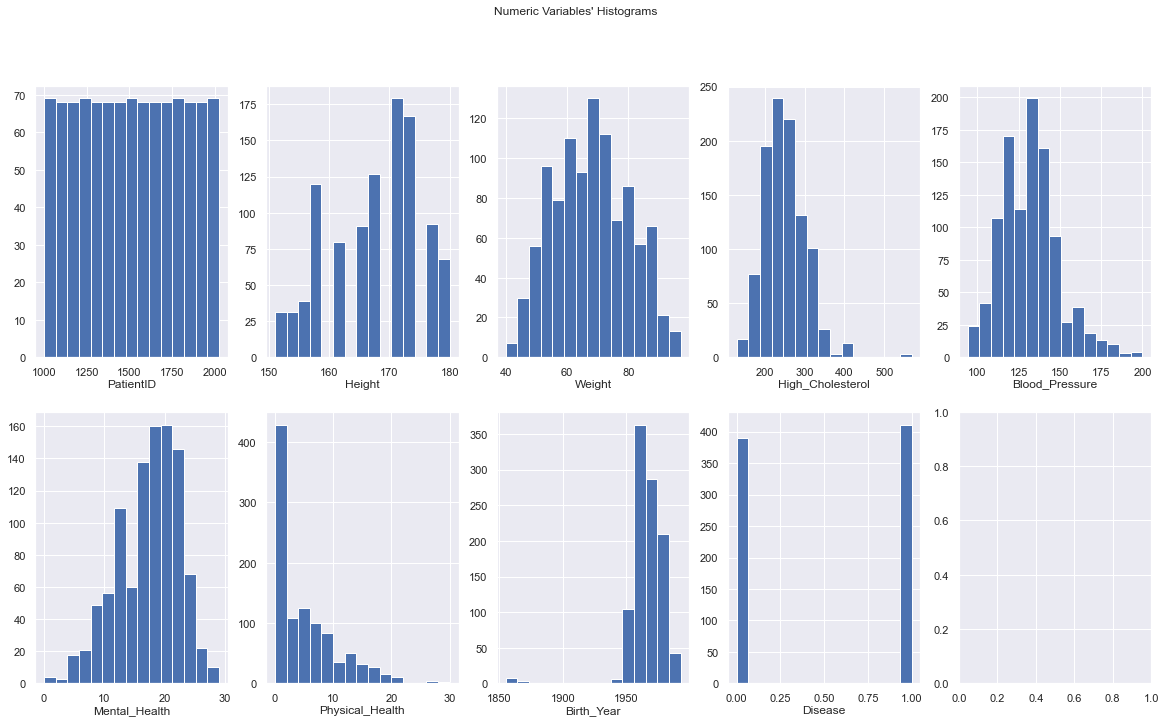

In [21]:
sns.set()
fig, axes = plt.subplots(2, ceil(len(numeric_cols) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), numeric_cols):
    ax.hist(data[feat], bins = 15)
    ax.set_title(feat, y=-0.13)
    
title = "Numeric Variables' Histograms"
plt.suptitle(title)

plt.show()

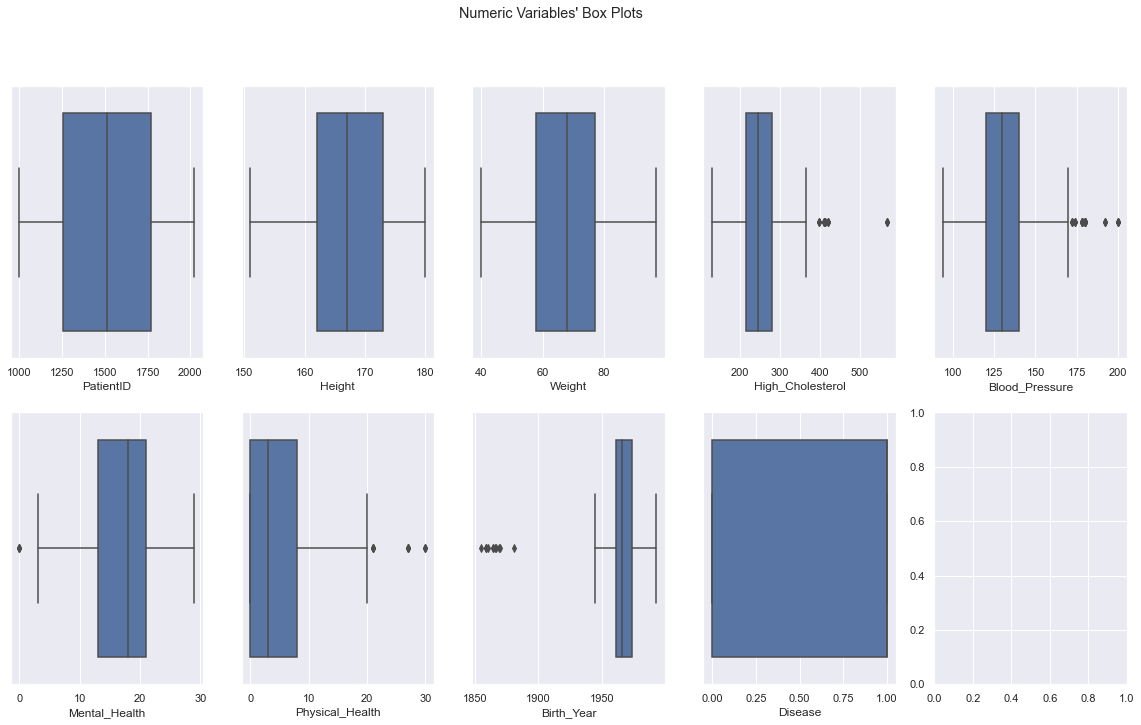

In [22]:
sns.set()
fig, axes = plt.subplots(2, ceil(len(numeric_cols) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), numeric_cols): 
    sns.boxplot(x=data[feat], ax=ax)
    
title = "Numeric Variables' Box Plots"
plt.suptitle(title)
plt.show()

# Feature Creation

1) Age <br>
2) Sex <br>
3) Ordinal variables <br>
4) Binary variables <br>
5) One Hot Encoding <br>
6) Feture selection

In [23]:
def feature_creation(df):
  ordinal_dicts = {

  'Drinking_Habit' : {'I do not consume any type of alcohol' : [0],
                      'I consider myself a social drinker' : [1],
                      'I usually consume alcohol every day' : [2]},

  'Water_Habit' : {'Between one liter and two liters' : [0],
                  'More than half a liter but less than one liter' : [1],
                  'Less than half a liter' : [2]},
                  
  'Fruit_Habit' : {'More than six pieces of fruit' : [0],
                  '5 to 6 pieces of fruit in average' : [1],
                  '3 to 4 pieces of fruit in average' : [2],
                  '1 to 2 pieces of fruit in average' : [3],
                  'Less than 1. I do not consume fruits every day.' : [4]},
                  
  'Diabetes' : {'Neither I nor my immediate family have diabetes.' : [0],
                "I don't have diabetes, but I have direct family members who have diabetes." : [1],
                'I have/had pregnancy diabetes or borderline diabetes' : [2],
                'I do have diabetes' : [3]},

  'Checkup' :  { 'Less than three months': [0],
                'Less than 3 years but more than 1 year' : [1],
                'More than 3 years' : [2],
                'Not sure': [3]}
                }
  # 1
  df['sex'] = df['Name'].str.contains('Mrs. ').astype(int)
  # 2
  df['age'] = date.today().year - df['Birth_Year']
  # 3
  drop_list = ['PatientID', 'Name', 'Birth_Year', 'Region', 'Education']
  for key in ordinal_dicts.keys():                  
    drinking_habit_map = pd.DataFrame(data = ordinal_dicts[key]).T.reset_index()
    drinking_habit_map.columns = [key, f'{key}_ord']
    df = df.merge(drinking_habit_map, how = 'left', on = [key])
    drop_list.append(key)
  # 4
  df.replace({"Exercise": {'Yes' : 0, 'No' : 1}}, inplace = True)
  df.replace({"Smoking_Habit": {'Yes' : 1, 'No' : 0}}, inplace = True)
  # 5
  one_hot = pd.get_dummies(df['Region'].str.lower(), prefix = '_geo_')
  one_hot_2 = pd.get_dummies(data['Education'].str.lower(), prefix = '_edu_')
  df = pd.concat([df, one_hot, one_hot_2], axis = 1)
  df = pd.concat([df, one_hot], axis = 1)
  df.drop(columns = drop_list, inplace = True)

  return df

data = feature_creation(data)
data.head()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,...,_edu__university incomplete (1 to 2 years),_geo__east midlands,_geo__east of england,_geo__london,_geo__north east,_geo__north west,_geo__south east,_geo__south west,_geo__west midlands,_geo__yorkshire and the humber
0,155,67,358,120,21,2,0,0,1.0,1,...,0,0,0,1,0,0,0,0,0,0
1,173,88,230,142,9,0,0,0,1.0,0,...,0,0,0,0,0,0,0,1,0,0
2,162,68,226,122,26,0,0,1,1.0,0,...,0,0,0,0,0,0,0,0,0,1
3,180,66,313,125,13,8,0,0,0.0,0,...,0,0,0,1,0,0,0,0,0,0
4,180,58,277,125,18,2,0,1,1.0,0,...,1,0,0,0,0,0,1,0,0,0


### 6) Feature selection (Random Forest)

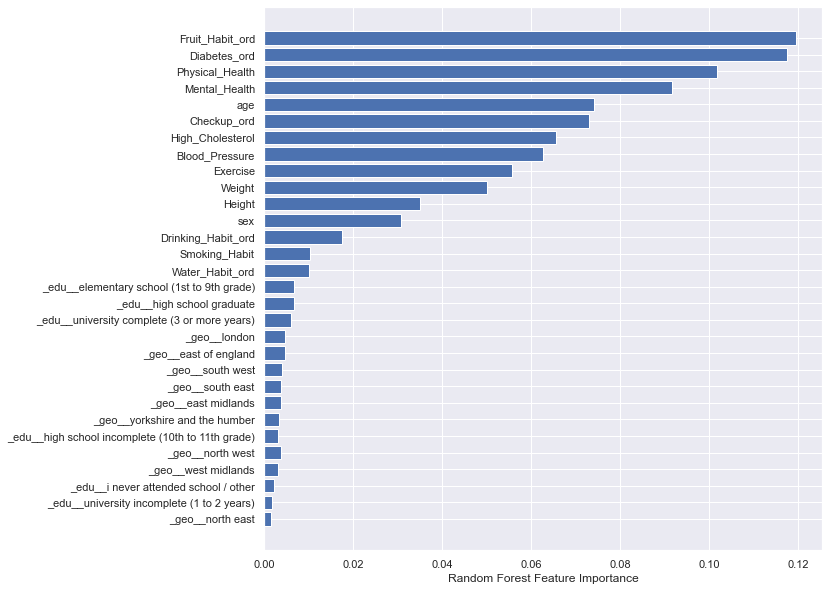

In [24]:
def rf_fi(data):
  train_part = data[data['Disease'].notnull()]
  X = train_part.drop(columns = ['Disease'])
  y = train_part[['Disease']]

  # Creation of default Random Forest Classifier to get feature importance
  clf = RandomForestClassifier() 
  clf.fit(X, y)

  sorted_idx = clf.feature_importances_.argsort()
  plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
  plt.xlabel("Random Forest Feature Importance")

plt.rcParams['figure.figsize'] = [10, 10]
rf_fi(data)

> ⚠ The variables related to education and region were found to have minimal impact on the classification model. As a result, it was determined that they would not be used.

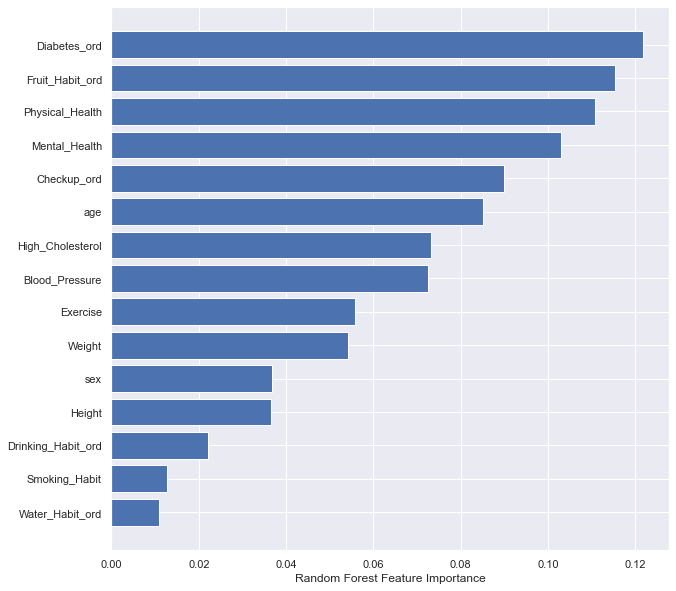

In [25]:
drop_list = []
for col in data.columns:
  if ('_geo_' in col) or ('_edu_'in col):
    drop_list.append(col)

data.drop(columns = drop_list, inplace = True)
rf_fi(data)

# Preprocessing with statistical information

1) Outliers removal<br>
2) Correlations check<br>


### 1) Outliers detection

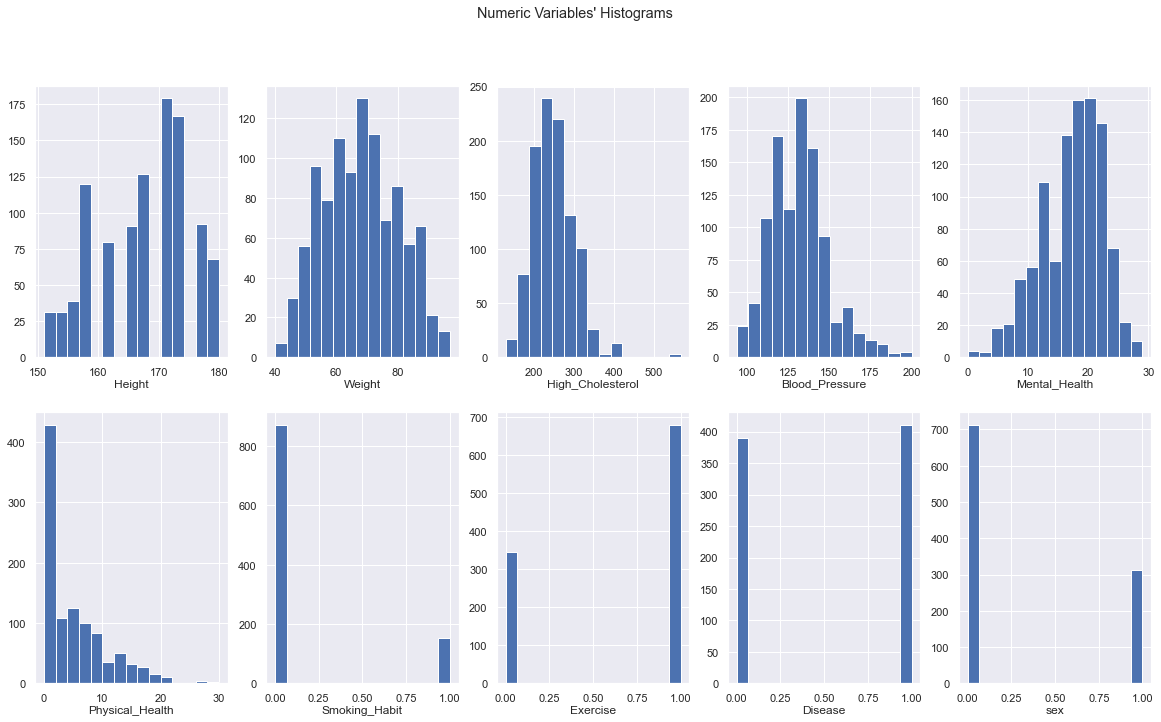

In [26]:
numeric_cols = data.dtypes[data.dtypes != 'object'].index

sns.set()
fig, axes = plt.subplots(2, ceil(len(numeric_cols[:-6]) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), numeric_cols[:-6]):
    ax.hist(data[feat], bins = 15)
    ax.set_title(feat, y=-0.13)
    
title = "Numeric Variables' Histograms"
plt.suptitle(title)

plt.show()

In [27]:
data.describe()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,age,Drinking_Habit_ord,Water_Habit_ord,Fruit_Habit_ord,Diabetes_ord,Checkup_ord
count,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,800.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,167.721951,67.821463,250.00000,131.611707,17.389268,4.738537,0.149268,0.663415,0.513750,0.304390,56.604878,1.485854,0.640976,3.245854,1.118049,2.323902
std,7.982877,12.251687,51.59251,17.516718,5.281313,5.596449,0.356527,0.472772,0.500124,0.460373,14.335373,0.528527,0.664295,1.030798,1.183676,0.620660
min,151.000000,40.000000,130.00000,94.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,58.000000,215.00000,120.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,1.000000,0.000000,3.000000,0.000000,2.000000
50%,167.000000,68.000000,244.00000,130.000000,18.000000,3.000000,0.000000,1.000000,1.000000,0.000000,57.000000,2.000000,1.000000,4.000000,1.000000,2.000000
75%,173.000000,77.000000,279.00000,140.000000,21.000000,8.000000,0.000000,1.000000,1.000000,1.000000,62.000000,2.000000,1.000000,4.000000,2.000000,3.000000
max,180.000000,97.000000,568.00000,200.000000,29.000000,30.000000,1.000000,1.000000,1.000000,1.000000,168.000000,2.000000,2.000000,4.000000,3.000000,3.000000


In [28]:
def outliers_remove(df, column):
  Q1 = df[column].quantile(.25)
  Q3 = df[column].quantile(.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  rep_func = lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
  df[column] = df[column].apply(rep_func)
  return df

for col in ['age', 'High_Cholesterol', 'Height', 'Weight', 'Blood_Pressure']:
  data = outliers_remove(data, col)
data.head()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,age,Drinking_Habit_ord,Water_Habit_ord,Fruit_Habit_ord,Diabetes_ord,Checkup_ord
0,155,67,358.0,120.0,21,2,0,0,1.0,1,58.0,2,0,4,0,2
1,173,88,230.0,142.0,9,0,0,0,1.0,0,54.0,1,0,4,0,3
2,162,68,226.0,122.0,26,0,0,1,1.0,0,49.0,1,1,4,0,2
3,180,66,313.0,125.0,13,8,0,0,0.0,0,65.0,2,1,4,2,3
4,180,58,277.0,125.0,18,2,0,1,1.0,0,55.0,1,1,3,2,2


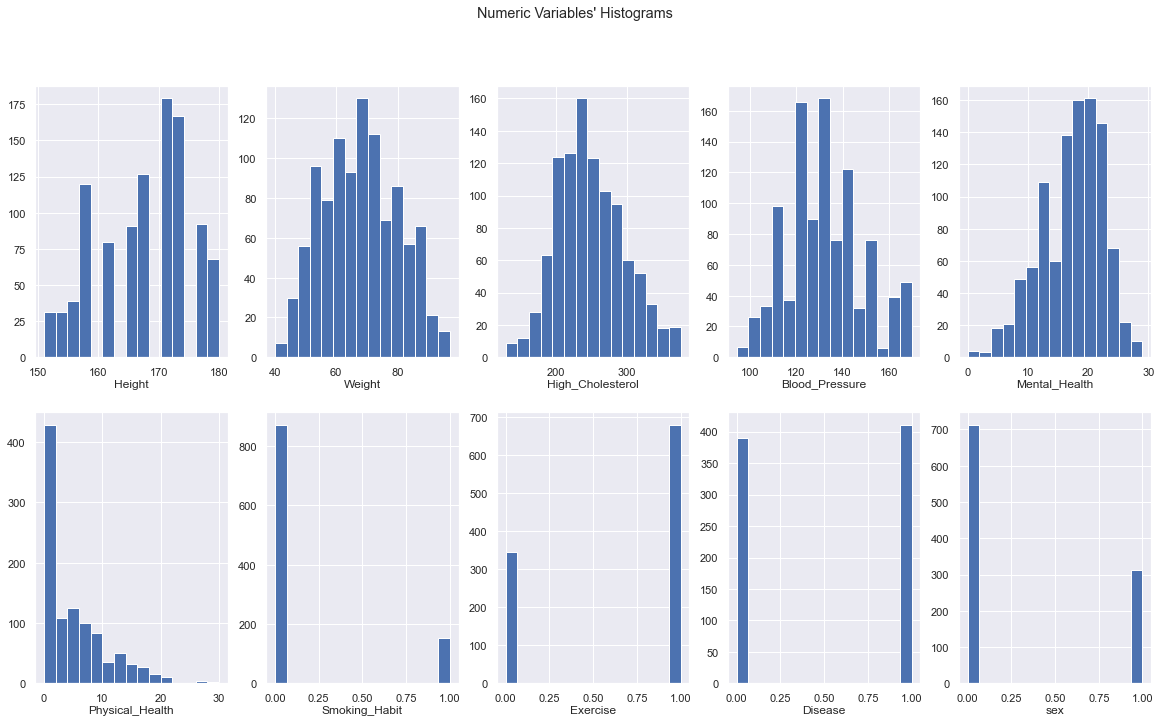

In [29]:
sns.set()
fig, axes = plt.subplots(2, ceil(len(numeric_cols[:-6]) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), numeric_cols[:-6]):
    ax.hist(data[feat], bins = 15)
    ax.set_title(feat, y=-0.13)
  
title = "Numeric Variables' Histograms"
plt.suptitle(title)
plt.show()

The most of distributions have taken a more recognizable bell-shaped form of a normal distribution. <br>

Outliers have vanished. <br>

To see new min-max values call **.describe()** function again:

In [30]:
data.describe()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,age,Drinking_Habit_ord,Water_Habit_ord,Fruit_Habit_ord,Diabetes_ord,Checkup_ord
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,800.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,167.721951,67.821463,248.981463,131.260488,17.389268,4.738537,0.149268,0.663415,0.513750,0.304390,55.702439,1.485854,0.640976,3.245854,1.118049,2.323902
std,7.982877,12.251687,47.746162,16.532208,5.281313,5.596449,0.356527,0.472772,0.500124,0.460373,9.463604,0.528527,0.664295,1.030798,1.183676,0.620660
min,151.000000,40.000000,130.000000,94.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,58.000000,215.000000,120.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,1.000000,0.000000,3.000000,0.000000,2.000000
50%,167.000000,68.000000,244.000000,130.000000,18.000000,3.000000,0.000000,1.000000,1.000000,0.000000,57.000000,2.000000,1.000000,4.000000,1.000000,2.000000
75%,173.000000,77.000000,279.000000,140.000000,21.000000,8.000000,0.000000,1.000000,1.000000,1.000000,62.000000,2.000000,1.000000,4.000000,2.000000,3.000000
max,180.000000,97.000000,375.000000,170.000000,29.000000,30.000000,1.000000,1.000000,1.000000,1.000000,81.500000,2.000000,2.000000,4.000000,3.000000,3.000000


In [31]:
data

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,age,Drinking_Habit_ord,Water_Habit_ord,Fruit_Habit_ord,Diabetes_ord,Checkup_ord
0,155,67,358.0,120.0,21,2,0,0,1.0,1,58.0,2,0,4,0,2
1,173,88,230.0,142.0,9,0,0,0,1.0,0,54.0,1,0,4,0,3
2,162,68,226.0,122.0,26,0,0,1,1.0,0,49.0,1,1,4,0,2
3,180,66,313.0,125.0,13,8,0,0,0.0,0,65.0,2,1,4,2,3
4,180,58,277.0,125.0,18,2,0,1,1.0,0,55.0,1,1,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,178,89,216.0,125.0,22,4,0,1,NaN,0,53.0,2,1,2,0,3
1021,154,63,187.0,138.0,25,6,0,1,NaN,1,36.0,2,2,4,0,2
1022,173,90,181.0,140.0,20,0,0,0,NaN,0,60.0,2,0,3,0,3
1023,155,45,240.0,138.0,18,0,0,0,NaN,1,46.0,1,1,4,0,2


### 2) Correlation check

In [32]:
rows = data[(data['Blood_Pressure'] == 120) & (data['Height'] == 155)]
rows

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,age,Drinking_Habit_ord,Water_Habit_ord,Fruit_Habit_ord,Diabetes_ord,Checkup_ord
0,155,67,358.0,120.0,21,2,0,0,1.0,1,58.0,2,0,4,0,2
122,155,68,182.0,120.0,5,0,1,1,1.0,1,61.0,2,0,4,2,2
329,155,46,215.0,120.0,10,7,0,1,1.0,1,69.0,1,1,4,2,2
625,155,63,248.0,120.0,20,5,0,1,1.0,1,51.0,2,0,4,3,2
825,155,56,223.0,120.0,19,7,0,1,NaN,1,51.0,2,1,4,2,2


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1025 entries, 0 to 1024
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Height              1025 non-null   int64  
 1   Weight              1025 non-null   int64  
 2   High_Cholesterol    1025 non-null   float64
 3   Blood_Pressure      1025 non-null   float64
 4   Mental_Health       1025 non-null   int64  
 5   Physical_Health     1025 non-null   int64  
 6   Smoking_Habit       1025 non-null   int64  
 7   Exercise            1025 non-null   int64  
 8   Disease             800 non-null    float64
 9   sex                 1025 non-null   int32  
 10  age                 1025 non-null   float64
 11  Drinking_Habit_ord  1025 non-null   int64  
 12  Water_Habit_ord     1025 non-null   int64  
 13  Fruit_Habit_ord     1025 non-null   int64  
 14  Diabetes_ord        1025 non-null   int64  
 15  Checkup_ord         1025 non-null   int64  
dtypes: flo

In [34]:
data['Height'].unique()

array([155, 173, 162, 180, 167, 158, 178, 154, 151, 165, 157, 172, 166,
       174, 171], dtype=int64)

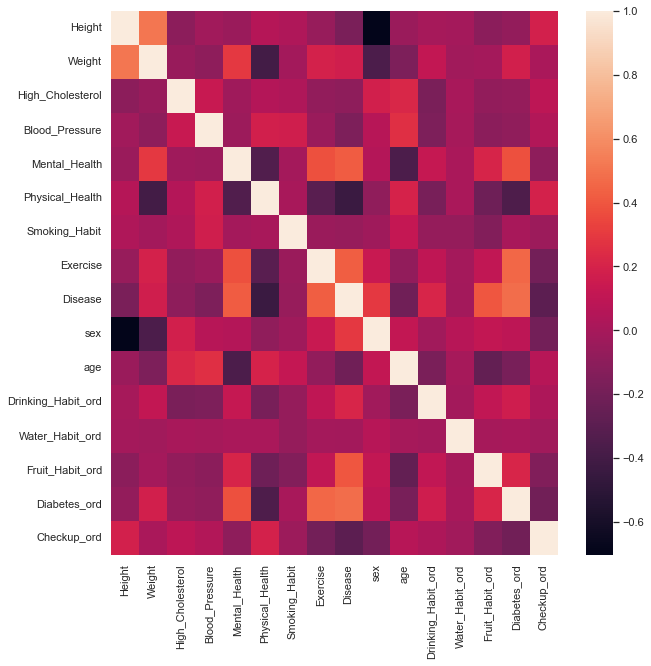

In [35]:
sns.heatmap(data.corr());

There are no highly correlated variables except "Sex" and "Height" as the absolute value is only ~0.6 and "Sex" is a binary variable

# Train / Val / Test split

In [36]:
test_df = data[data['Disease'].isnull()].drop(columns = ['Disease'])
train_df = data[data['Disease'].notnull()]

y = train_df['Disease']
X = train_df.drop(columns = ['Disease'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    shuffle = True, 
                                                    random_state = RS)

# Scaled copy of the data (for some models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

> ⚠  **train/val/test** devision is not used due to usage of K-Folds CV. It will help us to obtain metrics more accuratly and will help us to avoid possible overfitting.

# ML models
1) Logistic Regression<br>
2) SVM<br>
3) Decision Tree<br>
4) MLPClassifier<br>
5) Random Forest<br>
6) Gradient Boosting
7) CatBoost (not sklearn)<br>
8) XGBoost (not sklearn)<br>
9) AdaBoost<br>
10) Stacking Classifier<br>


In [37]:
plt.rcParams['figure.figsize'] = [8, 6]
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = RS)

def peformance_check(model, train_data):
  avg_f1 = np.mean(cross_val_score(model, train_data, y, scoring = 'f1', cv = cv))
  avg_acc = np.mean(cross_val_score(model, train_data, y, scoring = 'accuracy', cv = cv))
  avg_recall = np.mean(cross_val_score(model, train_data, y, scoring = 'recall', cv = cv))
  avg_prec = np.mean(cross_val_score(model, train_data, y, scoring = 'precision', cv = cv))
  return {'f1' : avg_f1, 'Accuracy' : avg_acc, 'Recall' : avg_recall, 'Precision' : avg_prec}

def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
    return n_scores

def return_results(models, X, y, plot = False, par = 'Parameter'):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    if plot:
      plt.figure(figsize=(10,6))
      plt.boxplot(results, labels = names, showmeans = True)
      plt.xticks(fontsize=10)
      plt.title("F1 evaluation")
      plt.xlabel(f'{par} value') 
      plt.ylabel('F1 distribution') 
      plt.show()

def get_models(values, template):
    models = dict()
    for value in values:
        models[str(value)] = eval(template)      
    return models

### 1. Logistic Regression

In [38]:
models = get_models(['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], template = "LogisticRegression(solver = value)")
return_results(models, X_train_scaled, y_train, plot = False)

>liblinear 0.839 (0.049)
>lbfgs 0.839 (0.049)
>newton-cg 0.839 (0.049)
>sag 0.839 (0.049)
>saga 0.839 (0.049)


In [39]:
parameters = {"penalty":["l1","l2"], "solver" : ['lbfgs']}
lreg = LogisticRegression()
logreg_cv = GridSearchCV(lreg, parameters, cv=cv)
logreg_cv.fit(X, y)
lr_bp = logreg_cv.best_params_
print('Best parameters:', lr_bp)

print('\nAverage Metrics using K-Folds CV:')
peformance_check(LogisticRegression(**lr_bp), X)

Best parameters: {'penalty': 'l2', 'solver': 'lbfgs'}

Average Metrics using K-Folds CV:


{'f1': 0.8333244373730277,
 'Accuracy': 0.8258333333333334,
 'Recall': 0.8459156020131631,
 'Precision': 0.8244871818043976}

### 2. SVM

F1 evaluation (on "C" Regularisation)
>3 0.928 (0.027)
>4 0.936 (0.029)
>5 0.940 (0.030)
>6 0.948 (0.027)
>7 0.950 (0.025)
>8 0.955 (0.023)
>9 0.957 (0.021)
>10 0.961 (0.020)
>11 0.963 (0.020)
>12 0.962 (0.020)
>13 0.963 (0.019)
>14 0.963 (0.019)


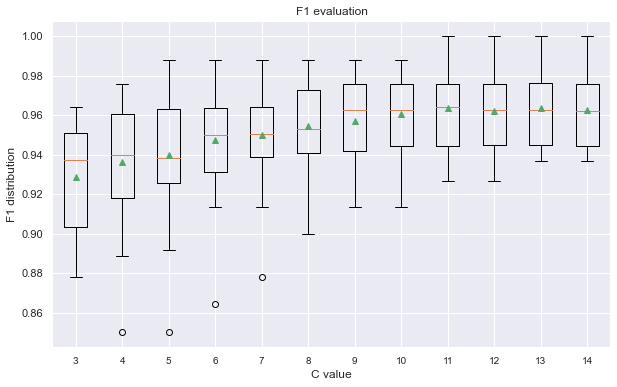

In [40]:
print('F1 evaluation (on "C" Regularisation)')
models = get_models(range(3, 15), template = "SVC(C = value)")
return_results(models, X_scaled, y, plot = True, par = 'C')

In [41]:
print('F1 evaluation (on "kernel")')
models = get_models(['linear', 'poly', 'rbf', 'sigmoid'], template = "SVC(kernel = value)")
return_results(models, X_train_scaled, y_train)

F1 evaluation (on "kernel")
>linear 0.831 (0.047)
>poly 0.900 (0.035)
>rbf 0.887 (0.041)
>sigmoid 0.806 (0.047)


In [42]:
# GridSearch
print('GridSearch of hyperparameters')
parameters = {"C":[10, 11, 12], 
              "kernel" : ['poly', 'rbf'],
              "random_state" : [RS]}
svm_cv = GridSearchCV(SVC(), parameters, cv=cv)
svm_cv.fit(X_train_scaled, y_train)

svm_bp = svm_cv.best_params_
print('Best parameters optained:', svm_bp)

print('\nAverage Metrics using K-Folds CV:')
peformance_check(SVC(**svm_bp), X_scaled)

GridSearch of hyperparameters
Best parameters optained: {'C': 10, 'kernel': 'rbf', 'random_state': 42}

Average Metrics using K-Folds CV:


{'f1': 0.9605868103377131,
 'Accuracy': 0.9595833333333333,
 'Recall': 0.9586140147115756,
 'Precision': 0.9635364731186745}

In [43]:
# Comparison with default model (scaled data)
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(SVC(random_state = RS), X_scaled)


Average Metrics using K-Folds CV (default model):


{'f1': 0.8938897368092111,
 'Accuracy': 0.8925000000000001,
 'Recall': 0.8824235385210994,
 'Precision': 0.9074466745945277}

In [44]:
# Comparison with default model (unscaled data)
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(SVC(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.7341060446396356,
 'Accuracy': 0.7091666666666667,
 'Recall': 0.7827332559039877,
 'Precision': 0.69333419210924}

### 3. Decision Tree

F1 evaluation (on "max_depth")
>4 0.843 (0.038)
>5 0.869 (0.040)
>6 0.913 (0.040)
>7 0.932 (0.034)
>8 0.953 (0.030)
>9 0.958 (0.026)
>10 0.960 (0.025)
>11 0.960 (0.025)
>12 0.962 (0.025)
>13 0.962 (0.025)
>14 0.962 (0.025)


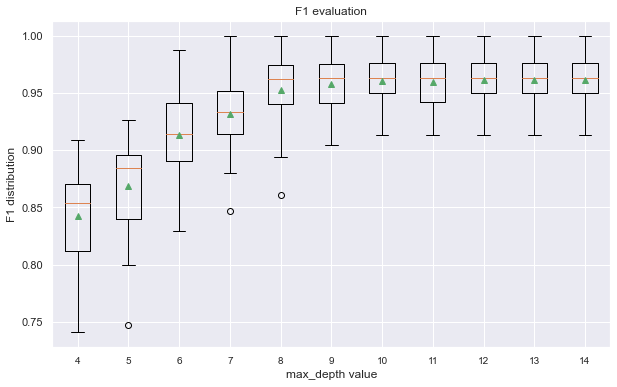

In [45]:
print('F1 evaluation (on "max_depth")')
models = get_models(range(4, 15, 1), template = "DecisionTreeClassifier(max_depth = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'max_depth')

In [46]:
# GridSearch
print('GridSearch of hyperparameters')
parameters = {"max_depth":[9, 10, 11, 12], 
              "criterion" : ['gini', 'entropy'],
              "random_state" : [RS]}

dtc_cv = GridSearchCV(DecisionTreeClassifier(), parameters, cv=cv)
dtc_cv.fit(X, y)
dtc_bp = dtc_cv.best_params_

print('Best parameters:', dtc_bp)
print('\nAverage Metrics using K-Folds CV:')
peformance_check(DecisionTreeClassifier(**dtc_bp), X)

GridSearch of hyperparameters
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'random_state': 42}

Average Metrics using K-Folds CV:


{'f1': 0.9704716465221013,
 'Accuracy': 0.9700000000000001,
 'Recall': 0.9610917537746805,
 'Precision': 0.9809618224153108}

In [47]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(DecisionTreeClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9615022810684548,
 'Accuracy': 0.9608333333333334,
 'Recall': 0.952168021680217,
 'Precision': 0.971936428100637}

### 4. MLPClassifier

In [48]:
print('F1 evaluations:')
print('\n > Check for best "hidden_layer_sizes"')
models = get_models([70, 80, 90, 100,], template = "MLPClassifier(hidden_layer_sizes = value, random_state = RS)")
return_results(models, X, y, plot = False)

print('\n > Check for best "activation" function')
models = get_models(['logistic', 'tanh', 'relu'], template = "MLPClassifier(activation = value, random_state = RS)")
return_results(models, X, y, plot = False)

print('\n > Check for best "learning_rate_init"')
models = get_models([5e-3, 1e-3, 5e-4], template = "MLPClassifier(activation = 'tanh', learning_rate_init = value, random_state = RS)")
return_results(models, X, y, plot = False)

F1 evaluations:

 > Check for best "hidden_layer_sizes"
>70 0.830 (0.042)
>80 0.816 (0.052)
>90 0.818 (0.058)
>100 0.815 (0.058)

 > Check for best "activation" function
>logistic 0.850 (0.039)
>tanh 0.866 (0.038)
>relu 0.815 (0.058)

 > Check for best "learning_rate_init"
>0.005 0.828 (0.049)
>0.001 0.866 (0.038)
>0.0005 0.851 (0.039)


In [49]:
# GridSearch
print('GridSearch of MLPClassifier hyperparameters')
parameters = {"hidden_layer_sizes":[78, 80, 82], 
              "activation" : ['logistic', 'tanh'],
              "learning_rate_init" : [1e-3],
              "random_state" : [RS]}
mlp_cv = GridSearchCV(MLPClassifier(), parameters, cv=cv)
mlp_cv.fit(X, y)
mlp_bp = mlp_cv.best_params_
print('Best parameters:', mlp_bp)
print('\nAverage Metrics using K-Folds CV:')
peformance_check(MLPClassifier(**mlp_bp), X)

GridSearch of MLPClassifier hyperparameters
Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': 78, 'learning_rate_init': 0.001, 'random_state': 42}

Average Metrics using K-Folds CV:


{'f1': 0.8581624997146841,
 'Accuracy': 0.8516666666666666,
 'Recall': 0.871873790166473,
 'Precision': 0.8472799997887411}

In [50]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(MLPClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.8150256741104644,
 'Accuracy': 0.8104166666666665,
 'Recall': 0.8323073945025166,
 'Precision': 0.819710145891423}

### 5. Random Forest

F1 evaluation (on "n_estimators")
>50 0.980 (0.014)
>60 0.980 (0.016)
>70 0.981 (0.017)
>80 0.980 (0.018)
>90 0.979 (0.017)
>100 0.979 (0.017)


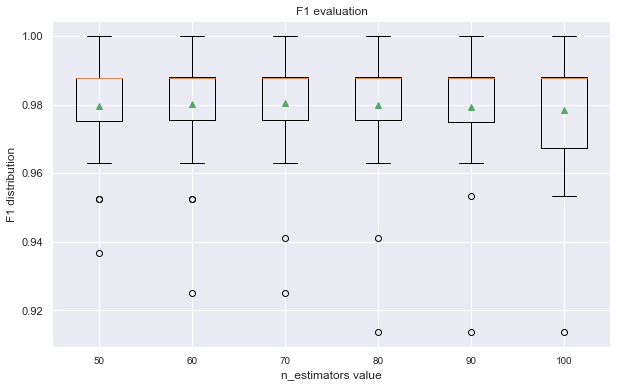

In [51]:
print('F1 evaluation (on "n_estimators")')
models = get_models(range(50, 110, 10), template = "RandomForestClassifier(n_estimators = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'n_estimators')

F1 evaluation (on "max_depth")
>4 0.884 (0.032)
>5 0.906 (0.026)
>6 0.932 (0.024)
>7 0.955 (0.027)
>8 0.971 (0.023)
>9 0.974 (0.020)
>10 0.975 (0.020)
>11 0.976 (0.017)
>12 0.978 (0.018)
>13 0.978 (0.018)


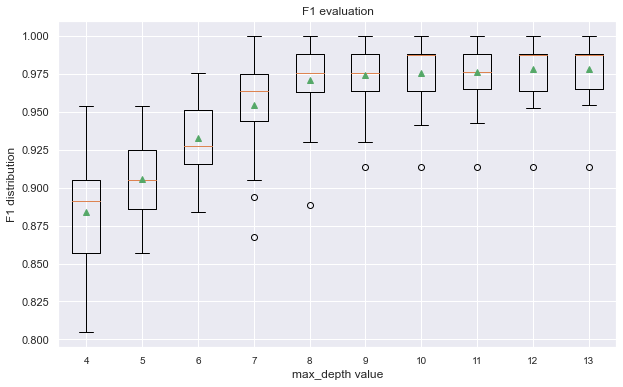

In [52]:
print('F1 evaluation (on "max_depth")')
models = get_models(range(4, 14, 1), template = "RandomForestClassifier(max_depth = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'max_depth')

In [53]:
print('F1 evaluations')
print('\n > Check for best "min_samples_split"')
models = get_models(range(2, 6, 1), template = "RandomForestClassifier(min_samples_split = value, random_state = RS)")
return_results(models, X, y)

print('\n > Check for best "min_samples_leaf"')
models = get_models(range(2, 6, 1), template = "RandomForestClassifier(min_samples_leaf = value, random_state = RS)")
return_results(models, X, y)

print('\n > Check for best "criterion"')
models = get_models(['gini', 'entropy'], template = "RandomForestClassifier(criterion = value, random_state = RS)")
return_results(models, X, y)

F1 evaluations

 > Check for best "min_samples_split"
>2 0.979 (0.017)
>3 0.979 (0.019)
>4 0.974 (0.023)
>5 0.967 (0.020)

 > Check for best "min_samples_leaf"
>2 0.960 (0.021)
>3 0.946 (0.027)
>4 0.935 (0.027)
>5 0.926 (0.033)

 > Check for best "criterion"
>gini 0.979 (0.017)
>entropy 0.976 (0.017)


In [54]:
# GridSearch
print('GridSearch of RandomForest hyperparameters')
parameters = {"n_estimators":[100, 110, 120], 
              "max_depth" : [9, 10, 11, None],
              "random_state" : [RS]}
              
rfc_cv = GridSearchCV(RandomForestClassifier(), parameters, cv=cv)
rfc_cv.fit(X, y)
rfc_bp = rfc_cv.best_params_

print('Best parameters:', rfc_bp)

print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(RandomForestClassifier(**rfc_bp), X)

GridSearch of RandomForest hyperparameters
Best parameters: {'max_depth': None, 'n_estimators': 100, 'random_state': 42}

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9785307735376099,
 'Accuracy': 0.9779166666666668,
 'Recall': 0.9781262098335269,
 'Precision': 0.9793426015277972}

In [55]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(RandomForestClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9785307735376099,
 'Accuracy': 0.9779166666666668,
 'Recall': 0.9781262098335269,
 'Precision': 0.9793426015277972}

### 6. Gradient Boosting

F1 evaluation (on "learning_rate")
>0.001 0.826 (0.044)
>0.01 0.854 (0.039)
>0.1 0.940 (0.025)
>0.2 0.970 (0.024)
>0.4 0.981 (0.018)
>0.6 0.981 (0.017)
>0.8 0.981 (0.017)
>1.0 0.983 (0.016)
>1.2 0.981 (0.018)


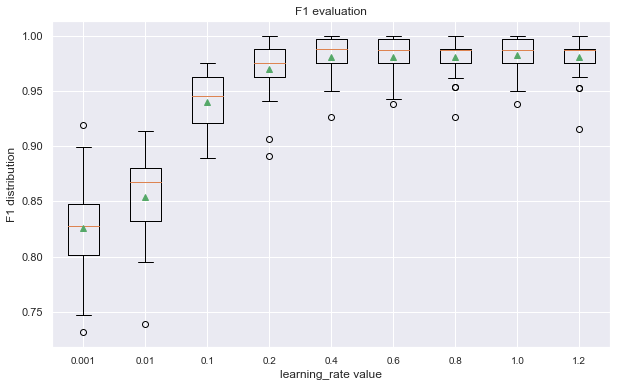

In [56]:
print('F1 evaluation (on "learning_rate")')
models = get_models([0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], 
                    template = "GradientBoostingClassifier(learning_rate = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'learning_rate')

F1 evaluation (on "n_estimators")
>100 0.940 (0.025)
>150 0.962 (0.021)
>200 0.970 (0.019)
>250 0.973 (0.019)
>300 0.977 (0.016)
>350 0.980 (0.015)
>400 0.980 (0.017)
>450 0.981 (0.016)
>500 0.981 (0.017)
>550 0.982 (0.017)
>600 0.981 (0.017)


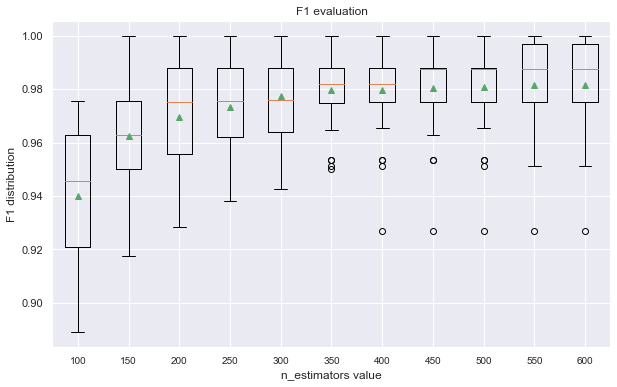

In [57]:
print('F1 evaluation (on "n_estimators")')
models = get_models(range(100, 650, 50), 
                    template = "GradientBoostingClassifier(n_estimators = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'n_estimators')

In [58]:
print('F1 evaluation (on "max_depth")')
models = get_models(range(3, 8), 
                    template = "GradientBoostingClassifier(max_depth = value, random_state = RS)")
return_results(models, X, y)

F1 evaluation (on "max_depth")
>3 0.940 (0.025)
>4 0.983 (0.017)
>5 0.984 (0.018)
>6 0.985 (0.015)
>7 0.978 (0.021)


In [59]:
# GridSearch
print('GridSearch of GradientBoosting hyperparameters')
parameters = {"n_estimators":[500, 550, 600], 
              "max_depth" : [4, 5, 6, None],
              "learning_rate" : [0.1, 0.2],
              "random_state" : [RS]}
              
gb_cv = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10)
gb_cv.fit(X, y)
gb_bp = gb_cv.best_params_
print('Best parameters:', gb_bp)

print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(GradientBoostingClassifier(**gb_bp), X)

GridSearch of GradientBoosting hyperparameters
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'random_state': 42}

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9875037016904804,
 'Accuracy': 0.9870833333333333,
 'Recall': 0.9902632597754548,
 'Precision': 0.9851626957525992}

In [60]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(GradientBoostingClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9401777161761511,
 'Accuracy': 0.9383333333333332,
 'Recall': 0.9408246225319398,
 'Precision': 0.9404971972645944}

By comparing a default GradientBoostingClassifier model, much better hyperparameters were obtained, resulting in an F1 score of **0.987**, as opposed to **0.940** when using K-Folds CV.

### 7. CatBoost

**CatBoost** is an open-source software library developed by **Yandex**. It provides a gradient boosting framework which among other features attempts to solve for Categorical features using a permutation driven alternative compared to the classical algorithm

F1 evaluation (on "learning_rate")
>0.001 0.906 (0.029)
>0.01 0.983 (0.019)
>0.1 0.989 (0.014)
>0.3 0.990 (0.012)
>0.5 0.989 (0.014)
>0.8 0.984 (0.017)
>1.0 0.984 (0.015)


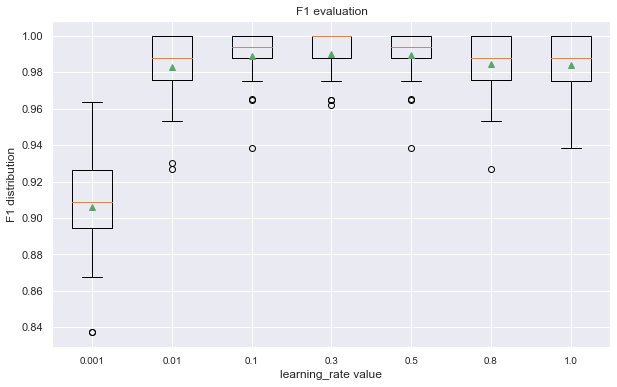

In [61]:
print('F1 evaluation (on "learning_rate")')
models = get_models([0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1.0], 
                    template = "CatBoostClassifier(learning_rate = value, silent = True, random_state = RS)")
return_results(models, X, y, plot = True, par = 'learning_rate')

F1 evaluation (on "iterations")
>100 0.927 (0.032)
>150 0.929 (0.029)
>200 0.976 (0.025)
>250 0.979 (0.021)
>300 0.977 (0.026)
>350 0.978 (0.021)
>400 0.979 (0.022)
>450 0.979 (0.023)


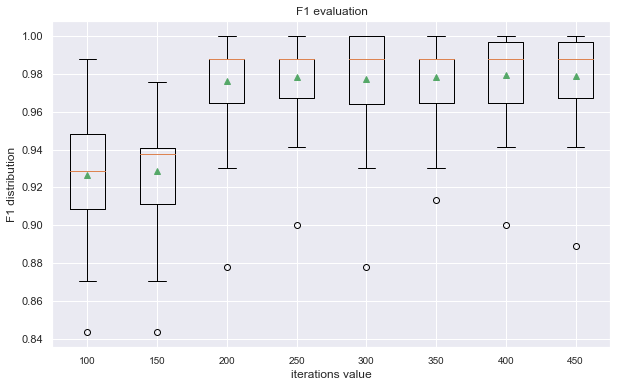

In [62]:
print('F1 evaluation (on "iterations")')
models = get_models(range(100, 500, 50), 
                    template = "CatBoostClassifier(iterations = value, silent = True, random_state = RS)")
return_results(models, X, y, plot = True, par = 'iterations')

In [63]:
print('F1 evaluation (on "depth")')
models = get_models(range(4, 11, 1), 
                    template = "CatBoostClassifier(depth = value, silent = True, random_state = RS)")
return_results(models, X, y)

F1 evaluation (on "depth")
>4 0.950 (0.030)
>5 0.970 (0.026)
>6 0.982 (0.021)
>7 0.988 (0.016)
>8 0.989 (0.015)
>9 0.989 (0.014)
>10 0.990 (0.014)


In [64]:
# GridSearch
print('GridSearch of CatBoost hyperparameters')
parameters = {"iterations":[250, 350, 400], 
              "depth" : [7, 8, None],
              "learning_rate" : [0.2, 0.3, 0.4],
              "random_state" : [RS],
              "silent" : [True]}
              
cat_cv = GridSearchCV(CatBoostClassifier(), parameters, cv=10)
cat_cv.fit(X, y)
cat_bp = cat_cv.best_params_
print('Best parameters:', cat_bp)

print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(CatBoostClassifier(**cat_bp), X)

GridSearch of CatBoost hyperparameters
Best parameters: {'depth': 8, 'iterations': 250, 'learning_rate': 0.2, 'random_state': 42, 'silent': True}

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9894657275538566,
 'Accuracy': 0.9891666666666666,
 'Recall': 0.9894502516453735,
 'Precision': 0.9897448351106888}

In [65]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(CatBoostClassifier(silent = True, random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9819105225578109,
 'Accuracy': 0.98125,
 'Recall': 0.9846109175377469,
 'Precision': 0.9795516136979552}

Comparing the obtained model with the default CatBoost classification, much better hyperparameters were found, resulting in an F1 score of **0.989** compared to **0.981** when using K-Fold CV.

### XGBoost
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (GBDT, GBM) that solve many data science problems in a fast and accurate way.

https://xgboost.readthedocs.io/en/stable/python/python_api.html

F1 evaluation (on "n_estimators")
>300 0.986 (0.018)
>350 0.985 (0.018)
>400 0.985 (0.018)
>450 0.986 (0.018)
>500 0.986 (0.018)
>550 0.986 (0.018)
>600 0.986 (0.018)
>650 0.986 (0.019)


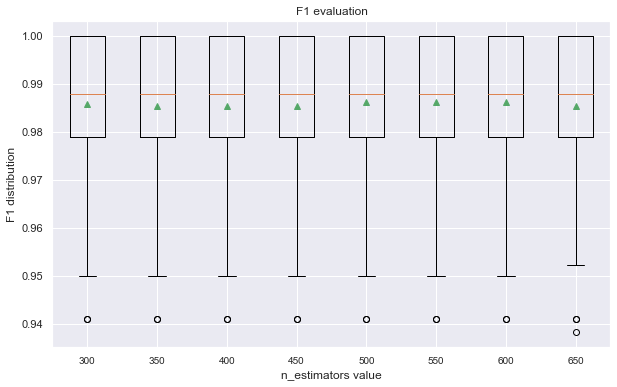

In [66]:
print('F1 evaluation (on "n_estimators")')
models = get_models(range(300, 700, 50), template = "XGBClassifier(n_estimators = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'n_estimators')

F1 evaluation (on "max_depth")
>4 0.985 (0.014)
>6 0.983 (0.019)
>8 0.983 (0.017)
>10 0.982 (0.017)
>12 0.982 (0.017)


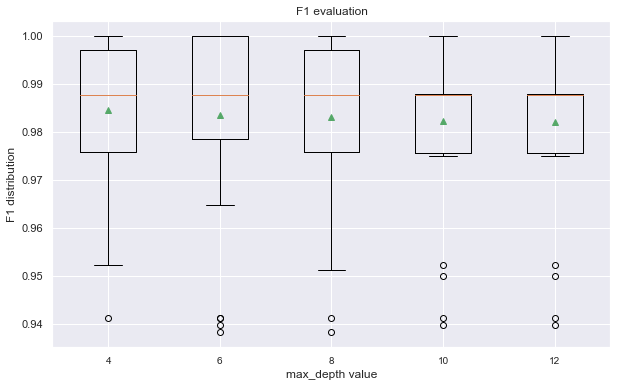

In [67]:
print('F1 evaluation (on "max_depth")')
models = get_models(range(4, 14, 2), template = "XGBClassifier(max_depth = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'max_depth')

In [68]:
print('Other F1 evaluations')
print('\n > Check for best "learning_rate"')
models = get_models([1, 5e-1, 1e-1, 1e-2, 5e-3], template = "XGBClassifier(learning_rate = value, random_state = RS)")
return_results(models, X, y, plot = False)

print('\n > Check for best "reg_alpha" (Lasso L1 Regularization)')
models = get_models([1, 1e-1, 1e-2, 5e-3, 1e-3, 0], template = "XGBClassifier(reg_alpha = value, random_state = RS)")
return_results(models, X, y, plot = False)

print('\n > Check for best "reg_lambda" (Ridge L2 Regularization)')
models = get_models([1, 1e-1, 1e-2, 5e-3, 1e-3, 0], template = "XGBClassifier(reg_lambda = value, random_state = RS)")
return_results(models, X, y, plot = False)

Other F1 evaluations

 > Check for best "learning_rate"
>1 0.980 (0.018)
>0.5 0.983 (0.018)
>0.1 0.984 (0.018)
>0.01 0.929 (0.036)
>0.005 0.908 (0.037)

 > Check for best "reg_alpha" (Lasso L1 Regularization)
>1 0.976 (0.021)
>0.1 0.985 (0.017)
>0.01 0.985 (0.017)
>0.005 0.984 (0.018)
>0.001 0.984 (0.018)
>0 0.983 (0.019)

 > Check for best "reg_lambda" (Ridge L2 Regularization)
>1 0.983 (0.019)
>0.1 0.984 (0.016)
>0.01 0.983 (0.017)
>0.005 0.983 (0.018)
>0.001 0.983 (0.018)
>0 0.983 (0.021)


In [69]:
parameters = {"n_estimators":[550, 600, 650], 
              "max_depth" : [5, 6, 7, None],
              "learning_rate" : [0.5, 0.1],
              "random_state" : [RS]}
              
xgb_cv = GridSearchCV(XGBClassifier(), parameters, cv=10)
xgb_cv.fit(X, y)
xgb_bp = xgb_cv.best_params_
print('Best parameters:', xgb_bp)

print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(XGBClassifier(**xgb_bp), X)

Best parameters: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 550, 'random_state': 42}

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.985083319361585,
 'Accuracy': 0.9845833333333334,
 'Recall': 0.9854239256678282,
 'Precision': 0.9851664880989895}

In [70]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(XGBClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9834783591208095,
 'Accuracy': 0.9829166666666668,
 'Recall': 0.9829849012775842,
 'Precision': 0.9843168006128867}

Comparing obtained model with a default XGBoost classification it has found much better hyperparameters which lead to **F1= 0.985** against 0.935 with use of K-Folds CV.

### AdaBoost

In [71]:

print('Best "base_estimator" search')
models = [('rf', AdaBoostClassifier(base_estimator = RandomForestClassifier(), random_state = RS)),
          ('dt', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = RS)),
          ('lr', AdaBoostClassifier(base_estimator = LogisticRegression(), random_state = RS)),]

for model in models:
  print('>', model[0], peformance_check(model[1], X))

Best "base_estimator" search
> rf {'f1': 0.9807418750290107, 'Accuracy': 0.9800000000000002, 'Recall': 0.9830236159504453, 'Precision': 0.9790310248038552}
> dt {'f1': 0.9674097664805503, 'Accuracy': 0.9666666666666668, 'Recall': 0.9627371273712736, 'Precision': 0.9729871289287643}
> lr {'f1': 0.8331785554640848, 'Accuracy': 0.8258333333333333, 'Recall': 0.8458575300038716, 'Precision': 0.8235004671792338}


F1 evaluation (on "max_depth" of base_estimator model)
>4 0.955 (0.029)
>5 0.946 (0.027)
>6 0.957 (0.026)
>7 0.966 (0.024)
>8 0.973 (0.022)
>9 0.976 (0.020)
>10 0.975 (0.018)
>11 0.980 (0.016)
>12 0.980 (0.015)
>13 0.981 (0.014)
>14 0.980 (0.015)
>15 0.980 (0.015)


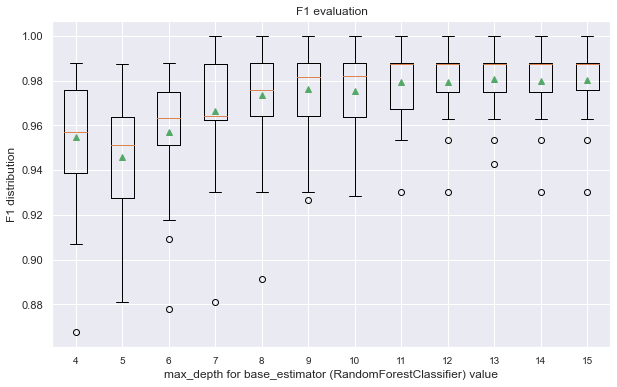

In [73]:
print('F1 evaluation (on "max_depth" of base_estimator model)')
models = get_models(range(4, 16), 
                    template = "AdaBoostClassifier(base_estimator = RandomForestClassifier(max_depth = value), random_state = RS)")
return_results(models, X, y, plot = True, par = 'max_depth for base_estimator (RandomForestClassifier)')

# Models Comparison

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:05<00:00, 47.31s/it]


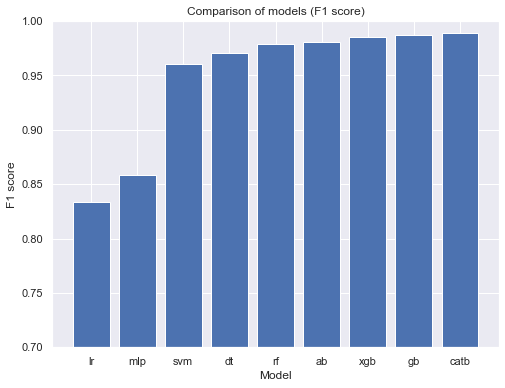

In [75]:
X_scaled = scaler.transform(X)

lr = LogisticRegression().set_params(**lr_bp)
svm = SVC().set_params(**svm_bp)
dtc = DecisionTreeClassifier().set_params(**dtc_bp)
mlp = MLPClassifier().set_params(**mlp_bp)
rf = RandomForestClassifier().set_params(**rfc_bp)
gb = GradientBoostingClassifier().set_params(**gb_bp)
catb = CatBoostClassifier().set_params(**cat_bp)
xgb = XGBClassifier().set_params(**xgb_bp)
ab = AdaBoostClassifier(base_estimator = RandomForestClassifier(max_depth = 13), random_state = RS)

models = [lr, svm, dtc, mlp, rf, gb, catb, xgb, ab]
need_scalling = [svm]
f1_scores, accs, recalls, precs = [], [], [], []
for model in tqdm(models):
  if model in need_scalling:
    X_data = X_scaled
  else:
    X_data = X.copy()
  f1_scores += [np.mean(cross_val_score(model, X_data, y, scoring = 'f1', cv = cv))]
  accs += [np.mean(cross_val_score(model, X_data, y, scoring = 'accuracy', cv = cv))]
  recalls += [np.mean(cross_val_score(model, X_data, y, scoring = 'recall', cv = cv))]
  precs += [np.mean(cross_val_score(model, X_data, y, scoring = 'precision', cv = cv))]

models = ['lr','svm','dt','mlp','rf', 'gb','catb','xgb', 'ab']
data_tuples = list(zip(models,f1_scores))
data_f1_scores = pd.DataFrame(data_tuples).rename(columns = {0:'Model', 1:'F1'}).set_index('Model')
data_tuples = list(zip(models, accs))
data_accs = pd.DataFrame(data_tuples).rename(columns = {0:'Model', 1:'Accuracy'}).set_index('Model')
data_tuples = list(zip(models, recalls))
data_recalls = pd.DataFrame(data_tuples).rename(columns = {0:'Model', 1:'Recall'}).set_index('Model')
data_tuples = list(zip(models, precs))
data_precs = pd.DataFrame(data_tuples).rename(columns = {0:'Model', 1:'Precision'}).set_index('Model')
data = pd.concat([data_f1_scores, data_accs, data_recalls, data_precs], axis = 1).sort_values('F1').reset_index()
plt.bar(data['Model'], data['F1'])
plt.ylim(0.7, 1)
plt.xlabel('Model') 
plt.ylabel('F1 score') 
plt.title("Comparison of models (F1 score)")
plt.show()

In [76]:
Final_result

,Model,F1,Accuracy,Recall,Precision
0,lr,0.833324,0.825833,0.845916,0.824487
1,mlp,0.858162,0.851667,0.871874,0.847280
2,svm,0.960587,0.959583,0.958614,0.963536
3,dt,0.970472,0.970000,0.961092,0.980962
4,rf,0.978531,0.977917,0.978126,0.979343
5,ab,0.980721,0.980000,0.983779,0.978233
6,xgb,0.985083,0.984583,0.985424,0.985166
7,gb,0.987504,0.987083,0.990263,0.985163
8,catb,0.989466,0.989167,0.989450,0.989745


We compared all models we created.<br>
As we can see the best model is **Random Forest**.<br>
But let's check a Stacking Classifier based on the best models

## Stacking Classifier

In [77]:
print('(GB + RF) + RF')
estimators = [('gb', GradientBoostingClassifier().set_params(**gb_bp)),
              ('rf', RandomForestClassifier().set_params(**rfc_bp))]
            
st = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state = RS))
print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(st, X)

(GB + RF) + RF

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9829111064989087,
 'Accuracy': 0.9825,
 'Recall': 0.9821525358110725,
 'Precision': 0.9841938620597156}

In [78]:
print('(GB + RF + SVM) + RF')
estimators = [('gb', GradientBoostingClassifier().set_params(**gb_bp)),
              ('rf', RandomForestClassifier().set_params(**rfc_bp)),
              ('svm', SVC(**svm_bp))]
            
st = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state = RS))
print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(st, X)

(GB + RF + SVM) + RF

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9874346460068821,
 'Accuracy': 0.9870833333333333,
 'Recall': 0.987824235385211,
 'Precision': 0.9874182727841263}

In [79]:
print('(GB + RF + SVM + AB) + RF')
estimators = [('gb', GradientBoostingClassifier().set_params(**gb_bp)),
              ('rf', RandomForestClassifier().set_params(**rfc_bp)),
              ('svm', SVC(**svm_bp)),
              ('ab', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth = 5), learning_rate = 1.5, random_state = RS))]

st = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state = RS))
print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(st, X)

(GB + RF + SVM + AB) + RF

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9834034505726729,
 'Accuracy': 0.9829166666666668,
 'Recall': 0.9829268292682927,
 'Precision': 0.9844230098286301}

## Final prediction

In [82]:
clf = RandomForestClassifier().fit(X.values, y.values)
preds = clf.predict(test_df.values)

sub = pd.DataFrame(data = {'PatientID' : pid, 'Disease' : preds})
sub['Disease'] = sub['Disease'].astype(int)
sub

,PatientID,Disease
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
220,220,0
221,221,1
222,222,0
223,223,1


# New Data Prediction

In [83]:
import pickle

In [84]:
file = open('random_forest_model.pkl', 'wb')

#dump infromation to that file
pickle.dump(clf, file)   #In the folder pickle file is created